# Transfer learning from Clara Train models
 
In this tutorial, we demonstrate transfer learning from a pretrained model in [Clara Train's Medical Model Archive format](https://docs.nvidia.com/clara/clara-train-sdk/pt/mmar.html).

The `monai.apps.load_from_mmar` command implements the following: 
- fetch a remote model if it is not cached (from Nvidia GPU cloud https://ngc.nvidia.com/)
- cache a local model file copy
- instantiate a network model with pre-trained weights.

The APIs enable direct access to the MMAR models in a pythonic way.


In this demo, we show that a PyTorch native pipeline could be configured to use the pretrained models,
and compare the following three cases:
1. regular training with a randomly initialised model (best mean Dice: 0.84)
<p><img src="../figures/mmar_1.png" width="50%" alt='mmar_1'></p>
2. loading from a pretrained model, without any model updating (best mean Dice: 0.86)
<p><img src="../figures/mmar_2.png" width="50%" alt='mmar_2'></p>
3. loading from a pretrained model, with finetuning (best mean Dice: 0.92)
<p><img src="../figures/mmar_0.png" width="50%" alt='mmar_0'></p>


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/transfer_mmar.ipynb)



## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, lmdb, tqdm]"

In [2]:
%matplotlib inline

## Setup imports

In [1]:
# Copyright 2020 - 2021 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import tempfile
import glob

import matplotlib.pyplot as plt
import torch
import numpy as np
from monai.apps import download_and_extract
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import (
    LMDBDataset,
    DataLoader,
    decollate_batch,
)
from monai.apps import load_from_mmar
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    ScaleIntensityRanged,
    Spacingd,
    Orientationd,
    CropForegroundd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotated,
    EnsureType,
    EnsureTyped,
)
from monai.utils import set_determinism
from monai.apps.mmars import RemoteMMARKeys

In [ ]:
# set the flag, it will change the initial model object.
PRETRAINED = True

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./mmar_cache


## Download dataset

Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

In [6]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
download_and_extract(resource, compressed_file, root_dir, md5)
data_dir = os.path.join(root_dir, "Task09_Spleen")

Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
File exists: ./mmar_cache/Task09_Spleen.tar, skipped downloading.
Non-empty folder exists in ./mmar_cache/Task09_Spleen, skipped extracting.


## Set MSD Spleen dataset path

In [7]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

# Setup transforms for training and validation
Relatively heavy data augmentations are used here to simulate a difficult training/validation set.

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=0.5,
            spatial_size=(96, 96, 96),
            rotate_range=(np.pi/18, np.pi/18, np.pi/5),
            scale_range=(0.05, 0.05, 0.05)
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        RandRotated(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            range_x=np.pi/18,
            range_y=np.pi/18,
            range_z=np.pi/5,
            prob=1.0,
            padding_mode=('reflection', 'reflection'),
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# Define LMDBDataset and DataLoader for training and validation

In [9]:
train_ds = LMDBDataset(data=train_files, transform=train_transforms, cache_dir=root_dir)
# initialize cache and print meta information
print(train_ds.info())

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

# the validation data loader will be created on the fly to ensure 
# a deterministic validation set for demo purpose.
val_ds = LMDBDataset(data=val_files, transform=val_transforms, cache_dir=root_dir)
# initialize cache and print meta information
print(val_ds.info())

100%|██████████| 9/9 [00:00<00:00, 29959.31it/s]

Accessing lmdb file: /workspace/mmar_cache/monai_cache.lmdb.
Accessing lmdb file: /workspace/mmar_cache/monai_cache.lmdb.


In [10]:
print(train_ds.info())

{'map_addr': 0, 'map_size': 1099511627776, 'last_pgno': 885751, 'last_txnid': 41, 'max_readers': 126, 'num_readers': 0, 'size': 32, 'filename': '/workspace/mmar_cache/monai_cache.lmdb'}


# Download the pretrained model from Nvidia Clara Train

By setting the global variable `PRETRAINED` to `True`, the following sections
will use a pretrained model from the `clara_pt_spleen_ct_segmentation` MMAR.


For more details, please see https://docs.monai.io/en/latest/apps.html#monai.apps.load_from_mmar

In [11]:
mmar = {
    RemoteMMARKeys.ID: "clara_pt_spleen_ct_segmentation_1",
    RemoteMMARKeys.NAME: "clara_pt_spleen_ct_segmentation",
    RemoteMMARKeys.FILE_TYPE: "zip",
    RemoteMMARKeys.HASH_TYPE: "md5",
    RemoteMMARKeys.HASH_VAL: None,
    RemoteMMARKeys.MODEL_FILE: os.path.join("models", "model.pt"),
    RemoteMMARKeys.CONFIG_FILE: os.path.join("config", "config_train.json"),
    RemoteMMARKeys.VERSION: 1,
}

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if PRETRAINED:
    print("using a pretrained model.")
    unet_model = load_from_mmar(
        mmar, mmar_dir=root_dir,
        map_location=device,
        pretrained=True)
    model = unet_model
else:
    print("using a randomly init. model.")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    )
model = model.to(device)

using a pretrained model.
Expected md5 is None, skip md5 check for file ./mmar_cache/clara_pt_spleen_ct_segmentation_1.zip.
File exists: ./mmar_cache/clara_pt_spleen_ct_segmentation_1.zip, skipped downloading.
Non-empty folder exists in ./mmar_cache/clara_pt_spleen_ct_segmentation_1, skipped extracting.

*** "clara_pt_spleen_ct_segmentation_1" available at ./mmar_cache/clara_pt_spleen_ct_segmentation_1.
*** Model: <class 'monai.networks.nets.unet.UNet'>
*** Model params: {'dimensions': 3, 'in_channels': 1, 'out_channels': 2, 'channels': [16, 32, 64, 128, 256], 'strides': [2, 2, 2, 2], 'num_res_units': 2, 'norm': 'batch'}

---
For more information, please visit https://ngc.nvidia.com/catalog/models/nvidia:med:clara_pt_spleen_ct_segmentation



### Alternative transfer learning setup
Using the MONAI modules, it is also possible to set
the learning rates for different layers for transfer learning.

```python
from monai.networks.utils import copy_model_state
from monai.optimizers import generate_param_groups

# copy all the pretrained weights except for variables whose name matches "model.0.conv.unit0"
pretrained_dict, updated_keys, unchanged_keys = copy_model_state(
    model, unet_model, exclude_vars="model.0.conv.unit0")
print("num. var. using the pretrained", len(updated_keys), ", random init", len(unchanged_keys), "variables.")
model.load_state_dict(pretrained_dict)

print([x[0] for x in model.named_parameters()])
print(unchanged_keys)

# stop gradients for the pretrained weights
for x in model.named_parameters():
    if x[0] in updated_keys:
        x[1].requires_grad = False
params = generate_param_groups(
    network=model,
    layer_matches=[lambda x: x[0] in updated_keys],
    match_types=["filter"],
    lr_values=[1e-4],
    include_others=False
)
optimizer = torch.optim.Adam(params, 1e-5)
```

## Create an optimizer and a loss function

In [13]:
loss_function = DiceFocalLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 5e-4)

## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after other epoch.  
Will save the model weights to file if got best validation accuracy.

In [ ]:
max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    set_determinism(seed=42)
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            set_determinism(seed=42)
            for val_data in DataLoader(val_ds, batch_size=1, num_workers=2):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.5)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

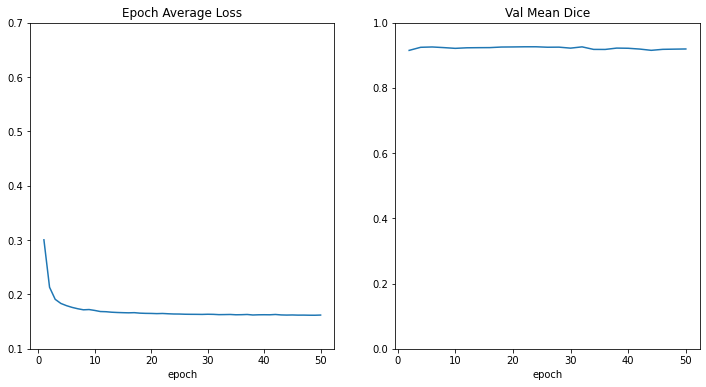

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.ylim([0.1, 0.7])
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim([0, 1.0])
plt.plot(x, y)
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [16]:
# if directory is None:
#     shutil.rmtree(root_dir)